2024/02/04

- Input: $z_e \in \mathbb{R}^{B C H \times W}$
- Embedding vectors: $e \in \mathbb{R}^{K \times D}$
- W次元の入力ベクトルに対し，K個の埋め込みベクトルのうち距離が最も小さいものを選択する．
  - これを全ての入力ベクトルに対して行う．
- 入力ベクトルと量子化後のベクトルが近くなるように損失を定義する．
  - VQ正則化項としてVAE全体の損失に加える．
  - さらにEMAを使うことで高速化可能

In [1]:
from torch import nn
import torch.nn.functional as F
import torch, dataclasses, time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

@dataclasses.dataclass
class Config:
    img_size = 64
    labels = 9
    bsz = 64
config = Config()

In [2]:
from torchvision import datasets, transforms, utils

transform = transforms.Compose([
    transforms.Resize(config.img_size),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])

def to_pil_image(x: torch.Tensor, nrow=8):  # (bsz, C, H, W)
    # grid = utils.make_grid(x.clamp(-1, 1) / 2 + 0.5, nrow)
    grid = utils.make_grid(x.clamp(0, 1), nrow)
    return transforms.functional.to_pil_image(grid)

dataset = datasets.ImageFolder("~/data/GochiUsa/ANIME/ANIME/", transform)
loader = torch.utils.data.DataLoader(dataset, config.bsz, shuffle=True, num_workers=24, pin_memory=True)

In [26]:
class RBFKernel:
    def __init__(self, beta=1, lam=0.01):
        self.beta = beta    # 大きいほどデータ点に強く反応，小さいとバリエーションがなくなる
        self.lam = lam      # 小さいほど過学習(近似曲線が激しくなる)

    def kernel(self, x):
        return (-self.beta * ((x[:, None] - self.xtr)**2).sum(-1)).exp()    # (len(x), len(xtr))

    def fit(self, x, y):
        self.xtr = x
        K = (self.kernel(x) + self.lam*torch.eye(len(x)).to(x)).inverse()   # (len(x), len(x))
        self.weight = K @ y # (len(x), len(y[0]))
        return self

    def predict(self, x):
        return self.kernel(x) @ self.weight

In [4]:
# https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=1):
        super().__init__()
        self._embedding_dim = embedding_dim     # D
        self._num_embeddings = num_embeddings   # K
        self._commitment_cost = commitment_cost
        self.emb = nn.Embedding(num_embeddings, embedding_dim)  # emb.weight.shape = (K, D)
        self.emb.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x: torch.Tensor): # (bsz, D, H, W)
        x = x.permute(0, 2, 3, 1).contiguous()  # (bsz, H, W, D)
        ze = x.view(-1, self._embedding_dim)    # (bsz*H*W, D)
        distances = (ze**2).sum(1, keepdim=True) + (self.emb.weight**2).sum(1) - 2 * ze @ self.emb.weight.T # (bsz*H*W, D)
        encoding_indices = distances.argmin(1).unsqueeze(1)     # (bsz*H*W, 1)
        encodings = torch.zeros(len(encoding_indices), self._num_embeddings, device=x.device)  # (bsz*H*W, K)
        encodings.scatter_(1, encoding_indices, 1)              # (bsz*H*W, K) (one-hot)
        quantized = (encodings @ self.emb.weight).view_as(x)    # (bsz, H, W, D)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = (x + (quantized - x).detach()).permute(0, 3, 1, 2).contiguous() # (bsz, D, H, W)
        avg_probs = encodings.mean(0)
        ppl = (-(avg_probs * (avg_probs + 1e-10).log()).sum()).exp()
        return quantized, encodings, loss, ppl

In [12]:
class ResidualStack(nn.Module):
    def __init__(self, hdim, res_hdim, layers):
        super().__init__()
        self._layers = nn.ModuleList([nn.Sequential(
            nn.ReLU(True), nn.Conv2d(hdim, res_hdim, 3, 1, 1, bias=False),
            nn.ReLU(True), nn.Conv2d(res_hdim, hdim, 1, 1, bias=False)
        ) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        for layer in self._layers:
            x = x + layer(x)
        return x.relu()

class Encoder(nn.Module):
    def __init__(self, in_channels=3, embdim=64, hdim=128, res_hdim=32, layers=2):
        super().__init__()
        self._conv_1 = nn.Conv2d(in_channels, hdim//2, 4, 2, 1)
        self._conv_2 = nn.Conv2d(hdim//2, hdim, 4, 2, 1)
        self._conv_3 = nn.Conv2d(hdim, hdim, 3, 1, 1)
        self._residual_stack = ResidualStack(hdim, res_hdim, layers)
        self.pre_vq_conv = nn.Conv2d(hdim, embdim, 1, 1)

    def forward(self, x: torch.Tensor): # (bsz, C=3, H=64, W=64)
        x = self._conv_1(x).relu()      # (bsz, hdim/2, H/2, W/2)
        x = self._conv_2(x).relu()      # (bsz, hdim,   H/4, W/4)
        x = self._conv_3(x)
        x = self._residual_stack(x)
        return self.pre_vq_conv(x)      # (bsz, embdim, H/4, W/4)

class Decoder(nn.Module):
    def __init__(self, in_channels=64, hdim=128, res_hdim=32, layers=2):
        super().__init__()
        self._conv_1 = nn.Conv2d(in_channels, hdim, 3, 1, 1)
        self._residual_stack = ResidualStack(hdim, res_hdim, layers)
        self._conv_trans_1 = nn.ConvTranspose2d(hdim, hdim//2, 4, 2, 1)
        self._conv_trans_2 = nn.ConvTranspose2d(hdim//2, 3, 4, 2, 1)

    def forward(self, x: torch.Tensor):     # (bsz, embdim,  H/4, W/4)
        x = self._conv_1(x)                 # (bsz, hdim,    H/4, W/4)
        x = self._residual_stack(x)
        x = self._conv_trans_1(x).relu()    # (bsz, hdim//2, H/2, W/2)
        return self._conv_trans_2(x)        # (bsz, 3, H, W)

In [13]:
class VQVAE(nn.Module):
    def __init__(self, chs=3, embdim=64, hdim=128, res_hdim=32, layers=2, K=512, cost=0.25):
        super().__init__()
        self.encoder = Encoder(chs, embdim, hdim, res_hdim, layers)
        self.vq = VectorQuantizer(K, embdim, cost)
        self.decoder = Decoder(embdim, hdim, res_hdim, layers)

    def forward(self, x):   # (bsz, C, H, W)
        h = self.encoder(x) # (bsz, c=hdim, h, w)
        z, encodings, loss, ppl = self.vq(h)
        x = self.decoder(z) # (bsz, C, H, W)
        return x, z, loss

1 epoch (931/931) 14s | loss: 0.1605 (0.0214 + 0.1392)


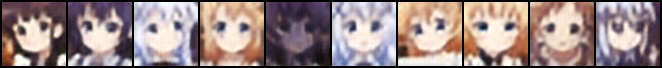

2 epoch (931/931) 27s | loss: 0.0081 (0.0068 + 0.0014)


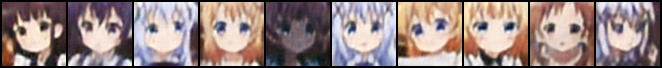

3 epoch (931/931) 41s | loss: 0.0077 (0.0050 + 0.0028)


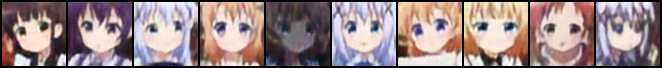

4 epoch (931/931) 56s | loss: 0.0078 (0.0044 + 0.0034)


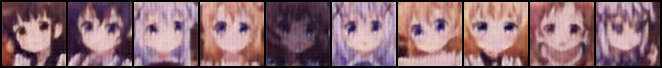

5 epoch (931/931) 71s | loss: 0.0075 (0.0040 + 0.0035)


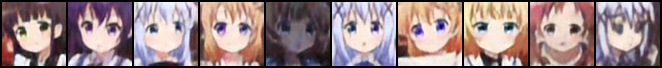

In [20]:
dim = 64
model = VQVAE(3, dim, cost=0.25).cuda()
optimizer = torch.optim.Adam(model.parameters())

torch.manual_seed(0)
# zte = torch.randn(config.labels, dim, config.img_size//4, config.img_size//4).cuda()    # (labels, dim)
xte = next(iter(loader))[0].cuda()

bgn = time.time()
for epoch in range(1, 1+5):
    model.train()
    n = loss_tr = recon_loss_tr = vq_loss_tr = 0
    for step, (x, y) in enumerate(loader, 1):
        x, y = x.cuda(), y.cuda()
        x_recon, z, vq_loss = model(x)
        recon_loss = F.mse_loss(x_recon, x)
        loss = (recon_loss + vq_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        p = len(x)
        n += len(x); recon_loss_tr += p*float(recon_loss); vq_loss_tr += p*float(vq_loss)
        print(f"{epoch} epoch ({step}/{len(loader)}) {time.time()-bgn:.0f}s | loss: {(recon_loss_tr+vq_loss_tr)/n:.4f} ({recon_loss_tr/n:.4f} + {vq_loss_tr/n:.4f})", end="\r")
    print()

    model.eval()
    if epoch % 1 == 0:
        with torch.no_grad():
            # xte_recon = model.decoder(zte).view(config.labels, *dataset[0][0].shape)
            xte_recon = model(xte[:10])[0]   # reconstruction
            display(to_pil_image(xte_recon, 10))

In [21]:
x, y = next(iter(loader))
with torch.no_grad():
    ze = model.encoder(x.cuda())
    z, encodings, loss, ppl = model.vq(ze)
    x_recon = model.decoder(z)

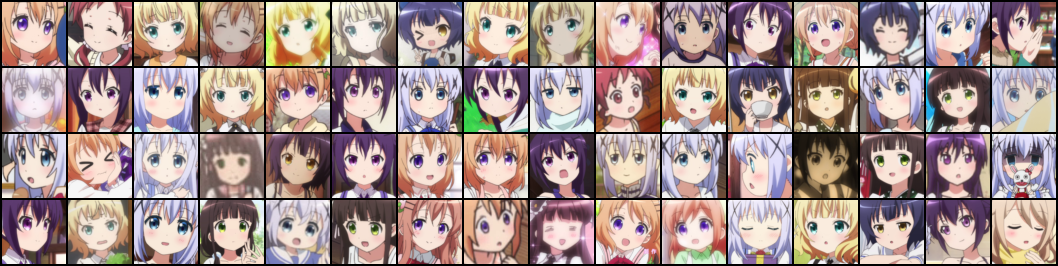

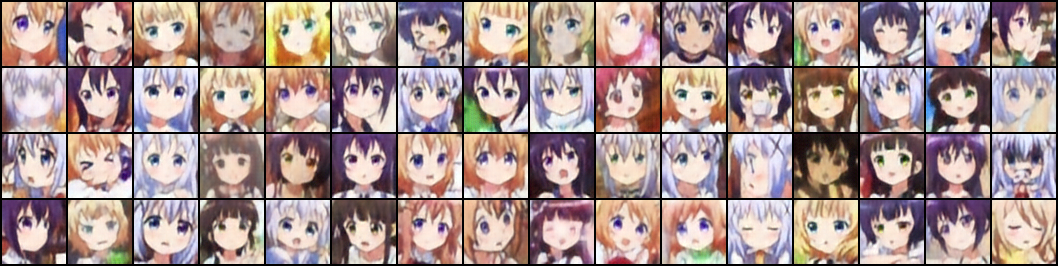

In [22]:
display(to_pil_image(x, 16))
display(to_pil_image(x_recon, 16))

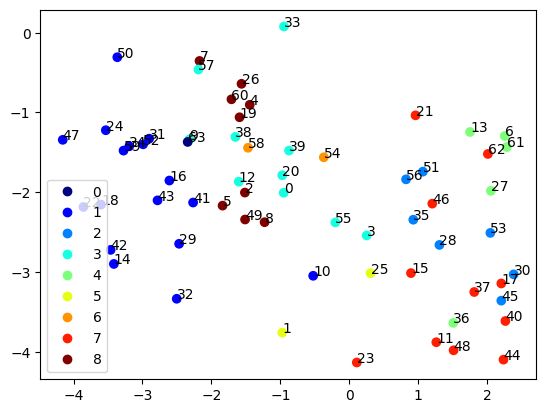

In [23]:
emb = TSNE(n_jobs=-1).fit_transform(z.flatten(1).cpu())
scatter = plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu(), cmap="jet")
plt.legend(*scatter.legend_elements())
for i in range(len(emb)):
    plt.annotate(str(i), (emb[i, 0], emb[i, 1]))

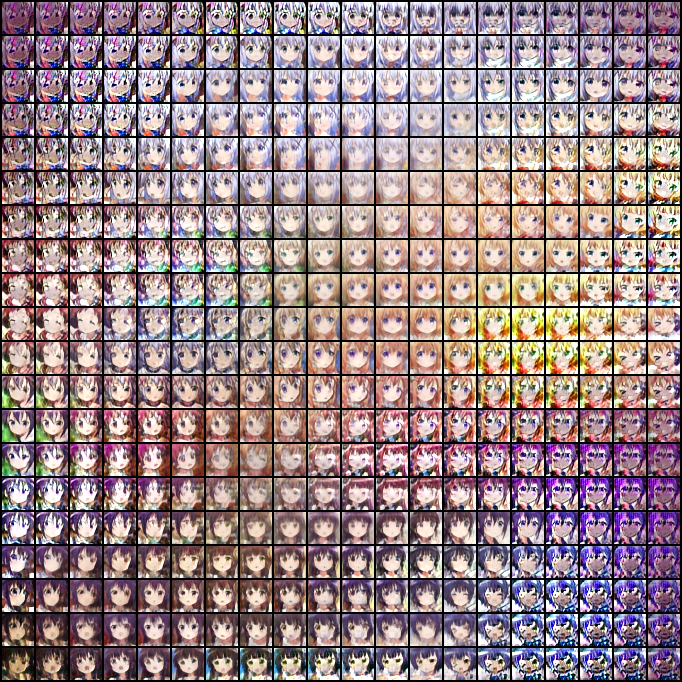

In [81]:
# 潜在表現に対する再構築した画像の分布
xax = torch.linspace(emb[:, 0].min(), emb[:, 0].max(), 20)
yax = torch.linspace(emb[:, 1].min(), emb[:, 1].max(), 20)
emb_te = torch.cartesian_prod(xax, yax)
with torch.no_grad():
    km = RBFKernel(1, 0.01).fit(torch.Tensor(emb), z.flatten(1).cpu())
    zte = km.predict(emb_te).cuda().view(-1, *z.shape[1:])
    x_recon = model.decoder(zte)[:, :, ::2, ::2]
display(to_pil_image(x_recon, len(xax)))